<a href="https://colab.research.google.com/github/yeonghun00/stock_public/blob/main/techincals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import ast

class Stock:
  def __init__(self, code):
    self.code = code
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_price(self, start:int='20180501', interval='day'):
    url ='https://api.finance.naver.com/siseJson.naver?symbol=' + self.code + ' &requestType=1&startTime=' \
    + start + '&endTime=' + str(datetime.datetime.now().date().strftime("%Y%m%d")) +  '&timeframe=' + interval

    result = requests.get(url)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    b = bs_obj.get_text()
    for i in ['\n', '\t', "\\", ' ']:
      b = b.replace(i,'')

    data = np.array(ast.literal_eval(b)[1:])

    dic = {'Date':list(map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'), data[:,0])), \
      'Open':np.array(data[:,1], int), 'High':np.array(data[:,2], int), 'Low':np.array(data[:,3], int),\
       'Close':np.array(data[:,4], int), 'Volume':np.array(data[:,5], int)}

    df = pd.DataFrame(data=dic)
    df = df.set_index('Date')
    return df
    
  def get_fundamental(self):
    url = 'https://finance.naver.com/item/main.nhn?code=' + self.code
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")

    ths = bs_obj.find_all("th", {'scope':'col'})
    ths = [th.get_text() for th in ths][10:-22]
    dates = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),ths))
    dates = list(map(lambda x: x + '(Y)', dates[:4])) + list(map(lambda x: x + '(M)', dates[4:]))

    tr = bs_obj.find_all("tbody")
    tds = tr[2].find_all('td')
    tds = [td.get_text() for td in tds]
    elements = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),tds))
    elements = list(map(lambda x: float(x) if x.replace('.','').isdigit() else np.nan, elements))

    temp_dict = {}
    cnt = 0
    index = ['sales', 'operating profit', 'net income', 'operating margin', 'net margin', 'roe', 'debt ratio', 'quick ratio', \
    'reserve ratio', 'eps', 'per', 'bps', 'pbr', 'dividend per share', 'dividend yield ratio', 'dividend payout ratio']

    for i in dates:
      temp_dict[i] = elements[cnt::10]
      cnt += 1

    df = pd.DataFrame.from_dict(temp_dict)
    df = df.set_index([pd.Index(index)])
    return df

In [ ]:
code = '207940'

stock = Stock(code)
df = stock.get_price('20210101', 'day')
df

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,819000,838000,804000,829000,182864
2021-01-05,825000,834000,818000,832000,119911
2021-01-06,828000,837000,816000,817000,145873
2021-01-07,824000,824000,816000,819000,116480
2021-01-08,821000,840000,815000,837000,263860
...,...,...,...,...,...
2021-05-17,930000,932000,874000,874000,546343
2021-05-18,888000,917000,875000,894000,399446
2021-05-20,896000,900000,868000,891000,220304


In [ ]:
import math

class Technicals:
  def __init__(self, df):
    self.df = df

  def get_mins(self, position:str='Close', adj_co:int=5):
      new_dict = {'date': [], position: []}
      for i in range(df.shape[0]):
          if (i - adj_co >= 0 and i + adj_co < df.shape[0]):
              if min(self.df.loc[self.df.index[i - adj_co:i + adj_co]][position].values) >= self.df.loc[self.df.index[i]][position]:
                  new_dict['date'].append(self.df.index[i])
                  new_dict[position].append(self.df.loc[self.df.index[i]][position])
              else:
                  new_dict['date'].append(self.df.index[i])
                  new_dict[position].append(None)
          else:
              new_dict['date'].append(self.df.index[i])
              new_dict[position].append(None)

      new_df = pd.DataFrame.from_dict(new_dict)
      new_df = new_df.set_index('date')

      return new_df

  def get_maxs(self, position:str='Close', adj_co:int=5):
      new_dict = {'date': [], position: []}
      for i in range(df.shape[0]):
          if (i - adj_co >= 0 and i + adj_co < df.shape[0]):
              if max(self.df.loc[self.df.index[i - adj_co:i + adj_co]][position].values) <= self.df.loc[self.df.index[i]][position]:
                  new_dict['date'].append(self.df.index[i])
                  new_dict[position].append(self.df.loc[self.df.index[i]][position])
              else:
                  new_dict['date'].append(self.df.index[i])
                  new_dict[position].append(None)
          else:
              new_dict['date'].append(self.df.index[i])
              new_dict[position].append(None)

      new_df = pd.DataFrame.from_dict(new_dict)
      new_df = new_df.set_index('date')

      return new_df

  def get_closeness(self, pos:str='max', adj_co:int=5)->list:
    if pos == 'min':
      li = [x for x in self.get_mins('Close', adj_co)['Close'] if not math.isnan(x)]
    elif pos == 'max':
      li = [x for x in self.get_maxs('Close', adj_co)['Close'] if not math.isnan(x)]
    current = self.df.iloc[-1]['Close']

    return li/current

  def get_influencial_volumes(self, ranking:int=5):
    return df['Volume'].sort_values().iloc[-ranking:]

  

<BarContainer object of 96 artists>

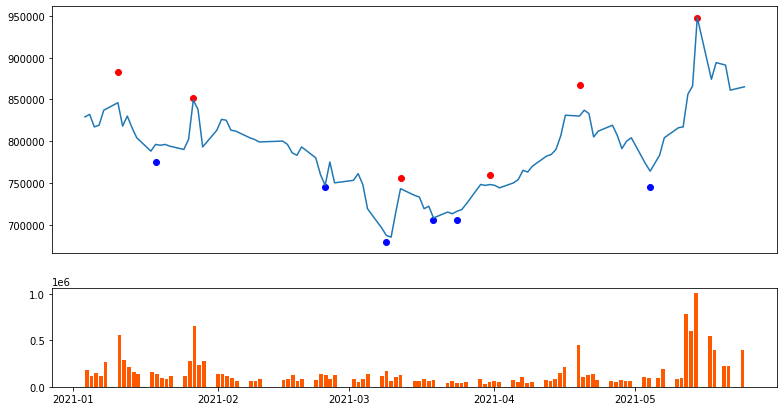

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

tech = Technicals(df)
fig, axs = plt.subplots(2,1,figsize=(13,7), gridspec_kw={'height_ratios': [5, 2]})
axs[0].plot(df['Close'])
axs[0].scatter(x=df.index, y=tech.get_maxs('High', 5), c='#ff0000', marker='o')
axs[0].scatter(x=df.index, y=tech.get_mins('Low', 5), c='#0008ff', marker='o')
axs[0].set_xticks([])


axs[1].bar(x=df.index, height=df['Volume'], color='#ff5900')


In [ ]:
tech.get_closeness('max', 5)

# find max among, cal increase prob
# find distance ==> (weight)

array([0.97803468, 0.98150289, 0.85895954, 0.86473988, 0.96763006,
       1.09595376])